# Anomaly Detection

#### Contents
- Overview
##### Density based Anomaly Detection
- Gaussian Density based Anomaly Detection
- MoG (Mixture of Gaussians)
- Parzen Window Density Estimation
- Local Outlier Factor

##### Model based Anomaly Detection
- Auto-Encoders
- Support Vector based Anomaly Detection
- Isolation Forests

## Overview

<p align="center">
    <img src="anomaly_images/blacksheep.png" width="400"/>
</p>


> Novel data are observations that deviate so much from other observations that they appear to ?have been generated by a different mechanism. - Hawkins, 1980

Anomaly detection, 즉 이상치 탐지는 정상 범주에서 벗어난 데이터를 탐지하는 Unsupervised 머신러닝의 task 중 하나이다. 이때 이상치와 노이즈 데이터는 엄밀히 구분되어야 한다. 이상치는 정상 데이터와 다른 분포를 가지고 있으며, 노이즈는 측정 과정에서의 무작위성에서 기반된다. 데이터셋 속 이상치는 대부분 엄청난 class imbalance 를 가지고 있으며, 이는 이상치 탐지의 어려움을 더욱 높인다.

<p align="center">
    <img src="anomaly_images/classvsanom2.png" width="400"/>
</p>


위와 같은 예시를 보면, 분류 문제와 이상치 탐지의 차이점을 쉽게 이해할 수 있다. 이상치 탐지는 다량의 정상 데이터를 통해 정상 범주를 정의하는 반면, 분류 문제는 두개의 범주를 가장 잘 설명하는 분류기를 fitting 한다.

<p align="center">
    <img src="anomaly_images/applications.png" width="400"/>
</p>


이상치 탐지는 굉장히 다양한 산업 분야에서 사용되며, 이에 다양한 방법론들 또한 존재한다. 이상치 탐지 방법론들은 크게 밀도 기반 방법론과 모델 기반 방법론으로 분류되며, 먼저 밀도 기반 방법론부터 알아보고자 한다.

## Density based Anomaly Detection

밀도 기반 이상치 탐지는 데이터의 밀도를 이용하여 이상치를 탐지한다. 주어진 데이터를 바탕으로 데이터가 생성되었을 분포를 fitting 한 뒤, 특정 객체가 해당 분포에서 생성되었을 확률이 낮다면 해당 객체를 이상치로 분류하는 방법론들이다.

In [106]:
import pandas as pd
import numpy as np
import scipy
import seaborn
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import random
df = pd.read_csv('creditcard.csv')

사용한 데이터는 [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download&select=creditcard.csv) 으로, 총 284,807 개의 샘플 중 492 개의 이상치를 가지고 있다. 실제 사용자들의 데이터로 구성되어 있기 때문에 변수명은 인코딩 되어있으며, `Class` 변수는 binary 값으로 0은 정상 데이터, 1은 이상치 데이터를 의미한다. 이상치의 비율은 0.172%로 굉장히 낮으므로, 이상치 탐지에서 자주 사용되는 데이터셋이다.

In [2]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

### Gaussian Density Estimation

Gaussain Density Estimation 은 밀도 기반 이상치 탐지 중 가장 기본적인 방법론이다. 이 방법론은 데이터를 가장 잘 설명하는 unimodal Gaussian 분포를 fitting 한 뒤, 특정 객체가 해당 분포에서 생성되었을 확률을 계산하여 이상치를 탐지한다. 이때, Gaussian 분포의 parameter 는 Maximum Likelihood Estimation (MLE) 을 통해 fitting 한다.

현재로썬 데이터셋의 변수들이 무엇을 의미하는지 모르기 때문에, 2개의 변수를 랜덤 추출하여 Gaussian 을 fitting 해보고자 한다.

In [20]:
varlist = df.columns.to_list()
rm = ['Time', 'Amount', 'Class']
for i in rm:
    varlist.remove(i)
rand_1 = random.choice(varlist)
rand_2 = random.choice(varlist)
print(rand_1, rand_2)

V27 V14


$$
p(\mathbf{x})=\frac{1}{(2 \pi)^{d / 2}|\mathbf{\Sigma}|^{1 / 2}} \exp \left[-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T \mathbf{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\right]
$$

위 식에서 실제로 추정해야 하는 것은 평균 벡터인 $\mu$ 와 공분산 행렬인 $\Sigma$ 이다. 데이터로 평균 벡터와 공분산 행렬을 구한 뒤, 특정 객체의 생성 확률을 계산 한 뒤, 해당 확률이 cutoff 보다 작다면 객체를 이상치로 판단하는 것이 Gaussian Density Estimation 이다.

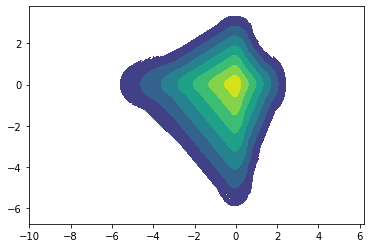

In [42]:
x = np.array(df[rand_1].sample(frac=0.001, random_state=1))
y = np.array(df[rand_2].sample(frac=0.001, random_state=1))
mu = [np.mean(x), np.mean(y)]
cov = [[np.var(x), np.cov(x, y)[0,1]], [np.cov(x, y)[0,1], np.var(y)]]
p = scipy.stats.multivariate_normal(mu, cov)
X, Y = np.meshgrid(x,y)
z = p.pdf(np.dstack([X, Y]))
plt.grid(False)
plt.contourf(X, Y, z)
plt.axis("equal")
plt.show()

위 그래프는 두개의 변수를 통해 평균벡터 `mu` 와 공분산행렬 `cov` 를 구한 뒤, 가우시안 분포를 fitting 한 예시이다. 전체 샘플 수를 사용할 시 메모리 부족으로 인해 0.001 만큼 샘플링을 진행하였다.

In [51]:
x = np.array(df[rand_1])
y = np.array(df[rand_2])
mu = [np.mean(x), np.mean(y)]
cov = [[np.var(x), np.cov(x, y)[0,1]], [np.cov(x, y)[0,1], np.var(y)]]
p = scipy.stats.multivariate_normal(mu, cov)

실제로 fitting 을 진행한 가우시안은 위 코드블럭의 `p` 이다. 데이터에서 샘플을 가져와 가우시안을 통해 확률을 계산해보면 해당 샘플이 이상치인지 판단 할 수 있게 된다.

In [67]:
anomaly_sample = df.loc[df.Class==1].iloc[0]
regular_sample = df.loc[df.Class==0].iloc[0]
anomaly_sample = np.array(anomaly_sample[[rand_1, rand_2]])
regular_sample = np.array(regular_sample[[rand_1, rand_2]])
print(f'Probability of the anomaly sample from the fitted Gaussian: {p.pdf(anomaly_sample)}')
print(f'Probability of the regular sample from the fitted Gaussian: {p.pdf(regular_sample)}')

Probability of the anomaly sample from the fitted Gaussian: 1.4987006657333505e-05
Probability of the regular sample from the fitted Gaussian: 0.36943974512952404


이상치 객체와 일반범주 객체를 샘플링 한 뒤, 해당 가우시안에서의 확률을 추출해본 결과 이상치의 확률이 현저히 낮은 것을 알 수 있다. 데이터 속 31개의 변수 중 불과 2개만 사용하였는데도 이상치의 확률을 낮게 측정하는 가우시안이 fitting 되었다.

#### Different Covariance Matricies

위에서 진행한 예시에서는 공분산 행렬을 full 행렬로 사용하였다. 하지만 공분산 행렬을 다르게 정의하여 가우시안을 fitting 할 수도 있다.

Spherical:

$$
\Sigma=\sigma^2\left[\begin{array}{ccc}
1 & \cdots & 0 \\
\vdots & \ddots & \vdots \\
0 & \cdots & 1
\end{array}\right]
$$

Diagonal:

$$
\Sigma=\left[\begin{array}{ccc}
\sigma_1^2 & \cdots & 0 \\
\vdots & \ddots & \vdots \\
0 & \cdots & \sigma_d^2
\end{array}\right]
$$

Full:

$$
\Sigma=\left[\begin{array}{ccc}\sigma_{11} & \cdots & \sigma_{1 d} \\ \vdots & \ddots & \vdots \\ \sigma_{d 1} & \cdots & \sigma_{d d}\end{array}\right]
$$

가우시안을 fitting 할 때 위와 같이 3개의 공분산 행렬을 사용 할 수 있다. 현재 사용하고 있는 데이터처럼 샘플 수가 굉장히 많은 경우, full 공분산 행렬을 사용할 시 computational complexity 가 기하급수적으로 늘어난다. 그렇기에 full 공분산 행렬은 샘플이 많아도 변수 수가 적으면 사용 할 수 있고, 변수 수가 많아진다면 Spherical 혹은 Diagonal 공분산 행렬을 사용해도 무방하다.

In [103]:
# Spherical Covariance Matrix
x = np.array(df[rand_1].sample(frac=0.001, random_state=1))
y = np.array(df[rand_2].sample(frac=0.001, random_state=1))
mu = [np.mean(x), np.mean(y)]
#cov = [[np.var(x), np.cov(x, y)[0,1]], [np.cov(x, y)[0,1], np.var(y)]]
avg_sig = sum(mu)/len(mu)
cov = [[avg_sig,0],[0,avg_sig]]
p = scipy.stats.multivariate_normal(mu, cov)
# X, Y = np.meshgrid(x,y)
# z = p.pdf(np.dstack([X, Y]))
# plt.grid(False)
# plt.contourf(X, Y, z)
# plt.axis("equal")
# plt.show()

ValueError: The input matrix must be symmetric positive semidefinite.

In [101]:
avg_sig = sum(mu)/len(mu)
cov = [[avg_sig,0],[0,avg_sig]]
cov

[[-0.024328506839983336, 0], [0, -0.024328506839983336]]

In [104]:
x = np.array(df[rand_1].sample(frac=0.001, random_state=1))
y = np.array(df[rand_2].sample(frac=0.001, random_state=1))
mu = [np.mean(x), np.mean(y)]
cov = [[np.var(x), np.cov(x, y)[0,1]], [np.cov(x, y)[0,1], np.var(y)]]
cov

[[0.5186666884042169, -0.008283629143894761],
 [-0.008283629143894761, 0.9297406332245876]]

In [102]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)
is_pos_def(cov)
#TODO: Why is this not positive definite?

False

------------------

### Mixture of Gaussians (MoG)

Gaussian Density Estimation 은 데이터가 unimodal 가우시안에서 생성되었다는 아주 강한 가정을 기반에 두고 있다. 하지만 실제 real life 데이터는 그럴 가능성이 매우 낮기 때문에, 여러개의 가우시안의 선형 결합으로 데이터를 표현하여 이상치 탐지에 이용하는 것이 Mixture of Gaussians (MoG) 이다.

$$
g\left(\mathbf{x} \mid \boldsymbol{\mu}_m, \boldsymbol{\Sigma}_m\right)=\frac{1}{(2 \pi)^{d / 2}\left|\boldsymbol{\Sigma}_m\right|^{1 / 2}} \exp \left[\frac{1}{2}\left(\mathbf{x}-\boldsymbol{\mu}_m\right)^T \boldsymbol{\Sigma}_m^{-1}\left(\mathbf{x}-\boldsymbol{\mu}_m\right)\right]
$$

정의할 가우시안의 개수 $m$ 은 hyperparameter이며, 데이터를 통해 $m$ 개의 가우시안의 fitting 을 진행한다.

$$
p(\mathbf{x} \mid \lambda)=\sum_{m=1}^M w_m g\left(\mathbf{x} \mid \boldsymbol{\mu}_m, \mathbf{\Sigma}_m\right)\\

\lambda=\left\{w_m, \boldsymbol{\mu}_m, \mathbf{\Sigma}_m\right\}, \quad m=1, \cdots, M
$$

가우시안들의 선형결합이 Fitting 이 된 후, 객체가 이 혼합 분포에서의 확률을 구하는 식은 위와 같다. 각 $m$ 개의 가우시안에 대한 확률을 구하는 것이 아니라, 가우시안들의 선형결합에서의 확률을 도출하는 것을 알 수 있다.

#### Expectation Maximization Algorithm

Gaussian density estimation 에서의 가우시안은 unimodal 하기 때문에 convex 하며, closed form solution 이 존재한다. 하지만 MoG 는 가우시안들의 선형결합이기 때문에, closed form solution 이 존재하지 않는다. 위 공식을 자세히 보면 실제 학습시켜야 하는 파라미터는 가중치 $w_m$ 인데, 가우시안의 파라미터를 구해야 가중치를 구할 수 있고 가중치를 구해야만 파라미터를 구할 수 있는 loop 에 빠진다.

이렇게 원하는 미지수들을 동시에 최적화 할 수 없을 때, EM 알고리즘을 사용 할 수 있다.

- Expectation: 현재 파라미터를 고정시킨 뒤, 조건부 확률 계산
- Maximization: 파라미터를 update 후 maximize likelihood

In [132]:
varlist = df.columns.to_list()
rm = ['Time', 'Amount', 'Class']
for i in rm:
    varlist.remove(i)
rand_1 = random.choice(varlist)
rand_2 = random.choice(varlist)
rand_3 = random.choice(varlist)
print(rand_1, rand_2, rand_3)

V22 V24 V10


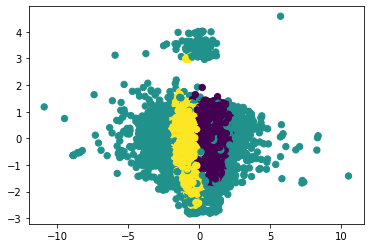

In [135]:
x = np.array(df[[rand_1, rand_2, rand_3]])
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(x)
labels = gmm.predict(x)
plt.scatter(x[:, 0], x[:, 1], c=labels, s=40, cmap='viridis');

Gaussian density estimation 예시와 마찬가지로 3개의 변수를 랜덤 추출 후, 3개의 가우시안을 fitting 하였다.

In [150]:
anomaly_sample = df.loc[df.Class==1].iloc[-1]
regular_sample = df.loc[df.Class==0].iloc[-1]
anomaly_sample = np.array(anomaly_sample[[rand_1, rand_2, rand_3]])
regular_sample = np.array(regular_sample[[rand_1, rand_2, rand_3]])
print(f'Probability of the anomaly sample from the fitted Gaussian: {gmm.predict_proba(anomaly_sample.reshape(1, -1))}')
print(f'Probability of the regular sample from the fitted Gaussian: {gmm.predict_proba(regular_sample.reshape(1, -1))}')

Probability of the anomaly sample from the fitted Gaussian: [[0.13972574 0.01607229 0.84420197]]
Probability of the regular sample from the fitted Gaussian: [[0.94121979 0.01230504 0.04647517]]


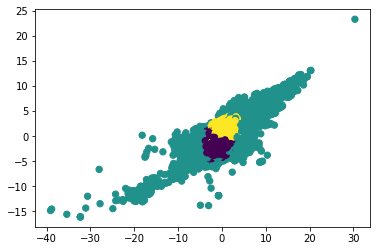

In [134]:
x = np.array(df[[rand_1, rand_2, rand_3]])
rng = np.random.RandomState(13)
x_stretched = np.dot(x, rng.randn(3, 3))
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(x_stretched)
labels = gmm.predict(x_stretched)
plt.scatter(x_stretched[:, 0], x_stretched[:, 1], c=labels, s=40, cmap='viridis');
